In [195]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import torch.nn.functional as F

In [196]:
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

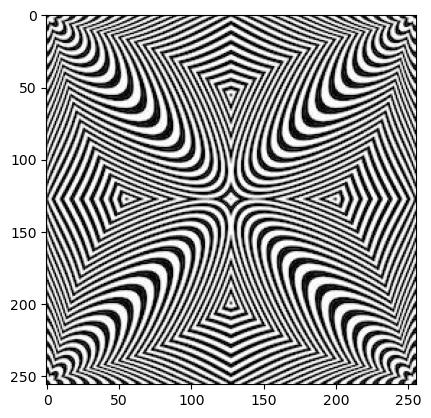

In [197]:
img = Image.open('illusion.jpg').convert('L')
plt.imshow(img, cmap='gray')

In [198]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
img = transform(img)

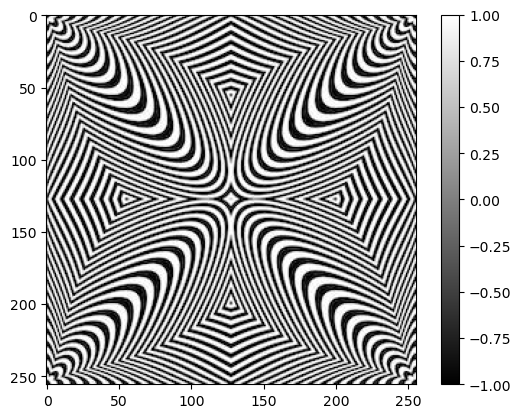

In [199]:
plt.imshow(img.reshape(256, 256), cmap='gray')
plt.colorbar()

In [200]:
class ImageFitting(torch.utils.data.Dataset):
    def __init__(self, img):
        super().__init__()
        self.pixels = img.view(-1, 1)
        self.coords = get_mgrid(256, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [201]:
kmm = np.sort(np.linspace(1, -1, 16, endpoint=False))
kx = np.zeros((128,))
ky = np.zeros((128,))
for i in range(8):
    for j in range(16):
        kx[i*16+j] = kmm[j]*np.cos(i * np.pi / 8)
        ky[i*16+j] = kmm[j]*np.sin(i * np.pi / 8)

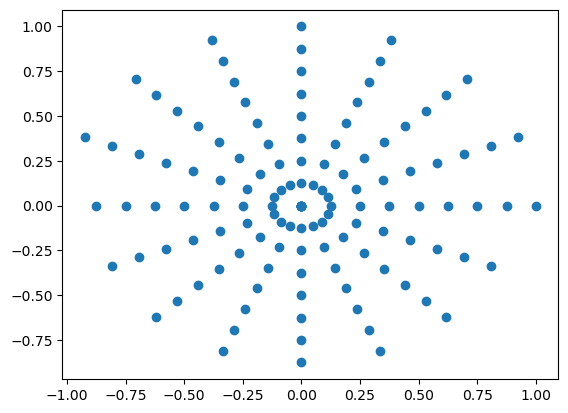

In [202]:
plt.scatter(kx, ky)

In [203]:
x = np.sort(np.linspace(1, -1, 256, endpoint=False))
y = np.linspace(1, -1, 256, endpoint=False)

In [204]:
H = np.zeros((128, 256**2), dtype=np.csingle)
for i in range(8):
    for j in range(16):
        for k in range(256):
            for l in range(256):
                H[i*16+j, k*256+l] = np.exp(-2*np.pi*1j*(kx[i*16+j]*x[l] + ky[i*16+j]*y[k]))

In [205]:
g = H.dot(img.reshape(-1, 1))

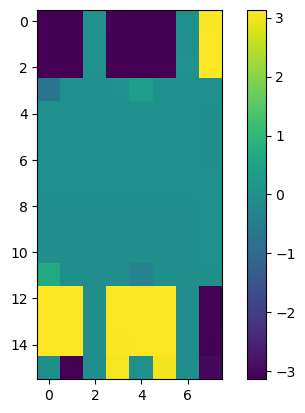

In [206]:
plt.imshow(np.angle(g).reshape(8, 16).T)
plt.colorbar()

In [207]:
cameraman = ImageFitting(img)
dataloader = torch.utils.data.DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

In [208]:
#from torchmetrics import MeanSquaredError, MeanAbsoluteError
class NeuralField(pl.LightningModule):
  def __init__(self, dataloader, H, g, n=64):
    super().__init__()
    self.dataloader = dataloader

    self.relu = torch.sin
    self.lin1 = nn.Linear(10, n)
    self.lin2 = nn.Linear(n, n)
    self.lin3 = nn.Linear(n, n)
    self.lin4 = nn.Linear(n, n)
    self.lin5 = nn.Linear(n, 1)
    self.out = nn.Tanh()
    self.B = nn.Parameter(torch.randn(5, 2))
    self.H = H
    self.g = g
    self.sobelx = nn.Parameter(torch.Tensor([[1, 0, -1],[2, 0, -2],[1, 0, -1]]).view(1, 1, 3, 3), requires_grad=False)
    self.sobely = nn.Parameter(torch.Tensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).view(1, 1, 3, 3), requires_grad=False)
    #self.criterion = nn.MSELoss(reduction='sum')
  
  def forward(self, x):
    x = torch.matmul(x, self.B.transpose(-1, -2))
    x = torch.cat((torch.sin(2*np.pi*x), torch.cos(2*np.pi*x)), dim=-1)
    x = self.relu(self.lin1(x))
    x = self.relu(self.lin2(x))
    x = self.relu(self.lin3(x))
    x = self.relu(self.lin4(x))
    x = self.lin5(x)
    return self.out(x)
  
  def shared_step(self, batch):
    x, y = batch
    pred = self(x)
    pred = pred.reshape(-1, 1)
    gpred = torch.matmul(self.H, pred.type(torch.cfloat))
    gradx = F.conv2d(pred.view(1, 1, 256, 256), self.sobelx)
    grady = F.conv2d(pred.view(1, 1, 256, 256), self.sobely)
    grad = torch.sqrt(torch.pow(gradx,2)+ torch.pow(grady,2))
    tv = 1 / (256**2) * torch.linalg.norm(grad)
    loss = torch.mean((gpred - self.g).abs()) + 0.001 * tv
    #if self.current_epoch%50==0:
        #plt.imshow(pred.detach().numpy().reshape(256, 256), cmap='gray')
        #plt.savefig(F"images/illusion_fourier_sine/image_{self.current_epoch}.png", dpi=160)
    return loss
  
  def training_step(self, batch, batch_idx):
    loss = self.shared_step(batch)
    return {'loss':loss}
  
  def training_step_end(self, outputs):
    loss = outputs['loss'].mean()
    self.log('train_loss', loss, prog_bar=True, on_epoch=True)
    return {"loss": loss}

  def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        return self(batch[0])
  
  def train_dataloader(self):
    return self.dataloader
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.007)
    return optimizer

In [209]:
Htensor = torch.tensor(H, dtype=torch.cfloat)
amptensor = torch.tensor(np.abs(g))
phasetensor = torch.tensor(np.angle(g))
gtensor = torch.tensor(g, dtype=torch.cfloat)
model = NeuralField(dataloader, Htensor, gtensor, 64)

trainer = pl.Trainer(
            max_epochs=1000,
            )
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | lin1 | Linear | 704   
1 | lin2 | Linear | 4.2 K 
2 | lin3 | Linear | 4.2 K 
3 | lin4 | Linear | 4.2 K 
4 | lin5 | Linear | 65    
5 | out  | Tanh   | 0     
--------------------------------
13.3 K    Trainable params
18        Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [210]:
class Image(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.coords = get_mgrid(256, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords

In [211]:
predCoords = Image()
predloader = torch.utils.data.DataLoader(predCoords, batch_size=1, pin_memory=True, num_workers=0)

In [212]:
pred = trainer.predict(model, predloader)

Predicting: 1it [00:00, ?it/s]

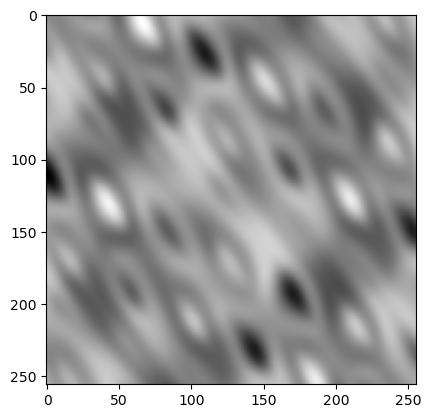

In [213]:
plt.imshow(pred[0].reshape(256, 256), cmap='gray')
plt.savefig('partb2_illusion.png', dpi=160)

In [214]:
a = torch.matmul(Htensor, pred[0].type(torch.cfloat))

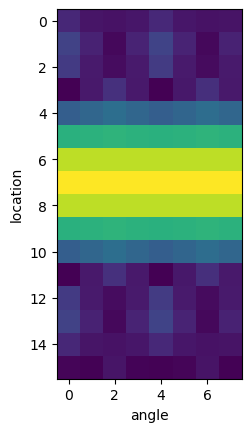

In [215]:
plt.imshow(a.abs().reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.savefig('pred2_abs_illusion.png', dpi=160)
#plt.colorbar()

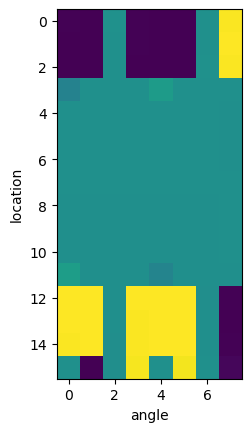

In [216]:
plt.imshow(a.angle().reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.savefig('pred2_phase_illusion.png', dpi=160)

In [112]:
mse = nn.MSELoss()
mse(a, torch.tensor(g))

RuntimeError: "mse_cpu" not implemented for 'ComplexFloat'